# MVP Summary: Hotel Rate Recommendation System

In [1]:
import pandas as pd
import numpy as np
import datetime
from sim import generate_simulation
from model_cancellations import get_otb_res, predict_cancellations

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

In [2]:
DATE_FMT = "%Y-%m-%d"
h1_capacity = 187
h2_capacity = 226
AOD = "2017-08-01"
AOD_dt = pd.to_datetime(AOD)

h1_res = pd.read_pickle("pickle/h1_res.pick")
h2_res = pd.read_pickle("pickle/h2_res.pick")
h1_dbd = pd.read_pickle("pickle/h1_dbd.pick")
h2_dbd = pd.read_pickle("pickle/h2_dbd.pick")
h1_sim = pd.read_pickle("pickle/h1_sim.pick")
h2_sim = pd.read_pickle("pickle/h2_sim.pick")

In [3]:
h1_res.shape

(40060, 69)

In [4]:
h2_res.shape

(79330, 71)

## Started with List of Reservations

In [5]:
h1_res.head()

,ResNum,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDate,LOS,CheckoutDate,PreviousBookings,ResMadeDate,NumPeople,CT_is_grp,CT_is_trn,CT_is_trnP,RS_No-Show,MS_Corporate,MS_Direct,MS_Groups,MS_Offline TA/TO,MS_Online TA,DC_Direct,DC_TA/TO,DC_Undefined,MEAL_FB,MEAL_HB,MEAL_SC,MEAL_Undefined,FROM_PRT,FROM_GBR,FROM_ESP,FROM_IRL,FROM_FRA,FROM_DEU,FROM_CN,FROM_NLD,FROM_USA,FROM_ITA,FROM_other,DT_NonRefundable,DT_Refundable,AgencyBooking,CompanyListed
0,0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,0,2015-07-01,0,2014-07-24,2,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,0,0,False,False
1,1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,0,2015-07-01,0,2013-06-24,2,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,0,0,False,False
2,2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,1,2015-07-02,0,2015-06-24,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,0,0,False,False
3,3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,1,2015-07-02,0,2015-06-18,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,0,0,True,False
4,4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2,2015-07-03,0,2015-06-17,2,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,0,0,True,False


## Converted to Day-By-Days

In [6]:
h1_dbd.head()

,DOW,Occ,RoomsSold,ADR,RoomRev,RevPAR,NumCancels,Trn_RoomsSold,Trn_ADR,Trn_RoomRev,Grp_RoomsSold,Grp_ADR,Grp_RoomRev,TrnP_RoomsSold,TrnP_ADR,TrnP_RoomRev,Cnt_RoomsSold,Cnt_ADR,Cnt_RoomRev,WE,WD,STLY_Date
2015-07-01,Wed,0.19,36.0,93.25,3356.83,17.95,5.0,30.0,95.91,2877.25,0.0,0.0,0.0,0.0,0.00,0.00,6.0,79.93,479.58,False,True,2014-07-02
2015-07-02,Thu,0.34,64.0,97.68,6251.33,33.43,14.0,43.0,107.71,4631.34,0.0,0.0,0.0,2.0,75.23,150.46,19.0,77.34,1469.53,False,True,2014-07-03
2015-07-03,Fri,0.43,81.0,99.41,8052.35,43.06,27.0,54.0,109.70,5923.95,0.0,0.0,0.0,2.0,75.23,150.46,25.0,79.12,1977.94,True,False,2014-07-04
2015-07-04,Sat,0.58,108.0,96.98,10473.47,56.01,39.0,71.0,107.65,7643.08,0.0,0.0,0.0,5.0,74.37,371.86,32.0,76.83,2458.53,True,False,2014-07-05
2015-07-05,Sun,0.65,122.0,97.56,11901.72,63.65,32.0,79.0,105.76,8354.73,1.0,153.0,153.0,5.0,74.37,371.86,37.0,81.68,3022.13,False,True,2014-07-06


## Time Traveling to Aug 1, 2017 as a  hotel revenue manager

We are trying to set the 'best' price for each hotel room for the month of August.

Let's generate a simulation...

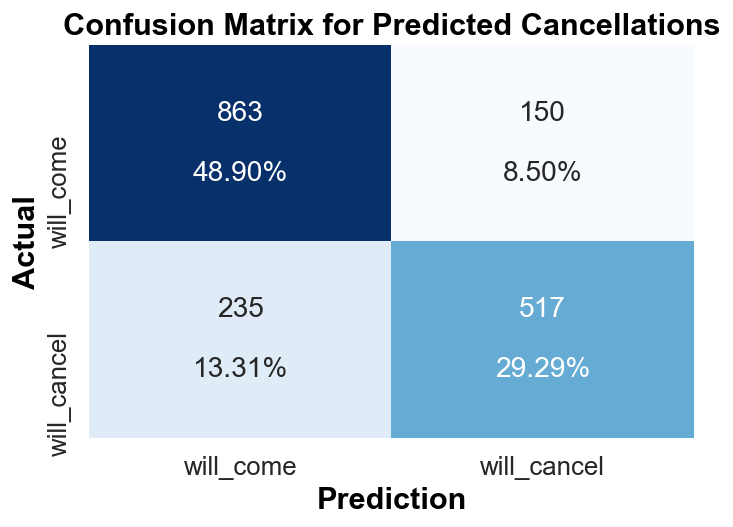

Optimal probability threshold (to maximize F-0.5): 0.67
F-0.5 Score: 0.756



In [9]:
h1_sim = generate_simulation(h1_dbd, AOD, 1, h1_res, verbose=0)

In [8]:
h1_sim.head()

,DOW,RoomsOTB,RevOTB,CxlForecast,Trn_RoomsOTB,Trn_RevOTB,Trn_CxlForecast,TrnP_RoomsOTB,TrnP_RevOTB,TrnP_CxlForecast,Grp_RoomsOTB,Grp_RevOTB,Grp_CxlForecast,Cnt_RoomsOTB,Cnt_RevOTB,Cnt_CxlForecast,Date,TM05_Date,TM15_Date,TM30_Date,WeekEndDate,WE,WD,STLY_Date,Occ,RevPAR,RemSupply,ADR_OTB,Trn_ADR_OTB,TrnP_ADR_OTB,Grp_ADR_OTB,Cnt_ADR_OTB,LYA_Occ,LYA_RoomsSold,LYA_ADR,LYA_RoomRev,LYA_RevPAR,LYA_NumCancels,LYA_Trn_RoomsSold,LYA_Trn_ADR,LYA_Trn_RoomRev,LYA_Grp_RoomsSold,LYA_Grp_ADR,LYA_Grp_RoomRev,LYA_TrnP_RoomsSold,LYA_TrnP_ADR,LYA_TrnP_RoomRev,LYA_Cnt_RoomsSold,LYA_Cnt_ADR,LYA_Cnt_RoomRev,Realized_Cxls,SellingPrice,TM05_RoomsOTB,TM05_ADR,TM05_TRN_OTB,TM05_TRN_ADR,TM05_TRNP_OTB,TM05_TRNP_ADR,TM05_GRP_OTB,TM05_GRP_ADR,TM05_CNT_OTB,TM05_CNT_ADR,TM15_RoomsOTB,TM15_ADR,TM15_TRN_OTB,TM15_TRN_ADR,TM15_TRNP_OTB,TM15_TRNP_ADR,TM15_GRP_OTB,TM15_GRP_ADR,TM15_CNT_OTB,TM15_CNT_ADR,TM30_RoomsOTB,TM30_ADR,TM30_TRN_OTB,TM30_TRN_ADR,TM30_TRNP_OTB,TM30_TRNP_ADR,TM30_GRP_OTB,TM30_GRP_ADR,TM30_CNT_OTB,TM30_CNT_ADR,STLY_RoomsOTB,STLY_ADR_OTB,STLY_SellingPrice,STLY_TM05_RoomsOTB,STLY_TM15_ADR,STLY_TM15_RoomsOTB,STLY_TM05_ADR,STLY_TM30_RoomsOTB,STLY_TM30_ADR,STLY_Trn_RoomsOTB,STLY_Trn_ADR_OTB,STLY_TM05_TRN_OTB,STLY_TM05_TRN_ADR,STLY_TM15_TRN_OTB,STLY_TM15_TRN_ADR,STLY_TM30_TRN_OTB,STLY_TM30_TRN_ADR,STLY_TrnP_RoomsOTB,STLY_TrnP_ADR_OTB,STLY_TM05_TRNP_OTB,STLY_TM05_TRNP_ADR,STLY_TM15_TRNP_OTB,STLY_TM15_TRNP_ADR,STLY_TM30_TRNP_OTB,STLY_TM30_TRNP_ADR,STLY_Grp_RoomsOTB,STLY_Grp_ADR_OTB,STLY_TM05_GRP_OTB,STLY_TM05_GRP_ADR,STLY_TM15_GRP_OTB,STLY_TM15_GRP_ADR,STLY_TM30_GRP_OTB,STLY_TM30_GRP_ADR,STLY_Cnt_RoomsOTB,STLY_Cnt_ADR_OTB,STLY_TM05_CNT_OTB,STLY_TM05_CNT_ADR,STLY_TM15_CNT_OTB,STLY_TM15_CNT_ADR,STLY_TM30_CNT_OTB,STLY_TM30_CNT_ADR
2017-08-01,Tue,184.0,35239.14,18.0,151.0,29935.72,16.0,13.0,2488.24,2.0,2.0,291.66,0.0,18.0,2523.52,0.0,2017-08-01,2017-07-27,2017-07-17,2017-07-02,2017-08-06,False,False,2016-08-02,0.98,188.44,21,191.52,198.25,191.40,145.83,140.20,0.98,183.0,170.00,31110.89,166.37,81.0,159.0,175.03,27829.05,0.0,0.0,0.0,14.0,152.47,2134.60,10.0,114.72,1147.24,134,204.00,177.0,192.05,144.0,199.23,13.0,191.40,2.0,145.83,18.0,140.20,180.0,191.78,147.0,198.75,13.0,191.40,2.0,145.83,18.0,140.20,170.0,188.18,139.0,195.88,11.0,177.17,2.0,145.83,18.0,140.20,183.0,170.00,178.09,182.0,167.36,180.0,168.12,180.0,166.00,159.0,175.03,158.0,172.89,156.0,172.07,156.0,170.50,14.0,152.47,14.0,152.47,14.0,152.47,14.0,152.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,114.72,10.0,114.72,10.0,114.72,10.0,114.72
2017-08-02,Wed,186.0,36141.47,19.0,152.0,30940.93,17.0,11.0,2004.24,2.0,2.0,291.66,0.0,21.0,2904.64,0.0,2017-08-02,2017-07-28,2017-07-18,2017-07-03,2017-08-06,False,False,2016-08-03,0.99,193.27,20,194.31,203.56,182.20,145.83,138.32,0.97,182.0,173.96,31660.62,169.31,86.0,159.0,178.23,28337.88,1.0,241.0,241.0,14.0,154.47,2162.60,8.0,114.89,919.14,131,206.75,183.0,193.75,149.0,203.06,11.0,182.20,2.0,145.83,21.0,138.32,183.0,192.39,149.0,201.39,11.0,182.20,2.0,145.83,21.0,138.32,174.0,187.86,143.0,196.84,9.0,162.76,2.0,145.83,20.0,139.16,182.0,173.96,181.69,173.0,172.51,176.0,172.87,179.0,170.49,159.0,178.23,151.0,177.65,154.0,177.14,157.0,174.75,14.0,154.47,14.0,154.47,14.0,154.47,14.0,154.47,1.0,241.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,114.89,8.0,114.89,8.0,114.89,8.0,114.89
2017-08-03,Thu,179.0,35705.54,17.0,140.0,29773.21,15.0,13.0,2225.28,2.0,3.0,453.06,0.0,23.0,3253.99,0.0,2017-08-03,2017-07-29,2017-07-19,2017-07-04,2017-08-06,False,False,2016-08-04,0.96,190.94,25,199.47,212.67,171.18,151.02,141.48,0.98,183.0,182.11,33326.17,178.21,96.0,153.0,185.74,28417.71,0.0,0.0,0.0,20.0,186.56,3731.12,10.0,117.73,1177.34,140,210.33,184.0,200.31,145.0,213.27,13.0,171.18,3.0,151.02,23.0,141.48,181.0,198.69,144.0,211.53,11.0,163.20,3.0,151.02,23.0,141.48,170.0,194.54,135.0,206.31,11.0,163.20,2.0,145.83,22.0,142.39,183.0,182.11,187.83,177.0,179.67,177.0,180.40,173.0,177.01,153.0,185.74,149.0,184.72,149.0,183.85,145.0,180.79,20.0,186.56,18.0,179.47,18.0,179.47,18.0,179.47,0.0,0.0,0.0,0.0,0

## What just happened?

* Estimated daily hotel selling prices based on the prices of all reservations made touching that date


* Predicted cancellations for on-the-books reservations
    * XGBoost with proba threshold optimized for F-Beta score in favor of precision
    
    
* Pulled last year actual statistics for the same stay date of last year
    * Used to calculate TY Gap to LY actual 
    
    
* Pulled same-time-last year data (STLY) for how many rooms we had on books for same date, last year
    * Calculate 'pace' using this
    
    
* Pulled trailing t-5, t-15, and t-30 booking statistics
    * How has the hotel been picking up recently, as compared to STLY?
   

## What's Next?

* Predicting demand for each future date at current (estimated) selling prices

* Change prices, calculate change in demand & total revenue at given price/demand

* Recommend the rate with the highest resulting revenue!
    